In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import datetime

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from threading import Timer
from timeit import default_timer as timer
from IPython.display import clear_output

# checking GPU erros

In [3]:
# physical_devices = tf.config.list_physical_devices("GPU")
# physical_devices
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
def preprocessiing():
   
    prep_dataset1 = pd.read_csv('../datasets/dataset_test_02_07.csv', delimiter=",")
    df = prep_dataset1.iloc[:,1:4]
    WINDOW = 35

    for i in np.arange(df.shape[0]):    
        init = i*WINDOW
        init2 = (i+1)*WINDOW
        if(init2<df.shape[0]):
            df.iloc[init:init+WINDOW,2] =  df.iloc[init2,2]
    df2 = normalizing(df)
    train_size = int(len(df2) * 0.8)
    test_size = len(df2) - train_size
    return df2.iloc[0:train_size], df2.iloc[train_size:len(df2)]

In [5]:
def normalizing(dataset):
    df_norm = pd.read_csv('../datasets/dataset_test_02_07.csv', delimiter=",")
    df_norm = df_norm.iloc[:,1:4]
    scaler = StandardScaler().fit(df_norm)

    scaler = scaler.fit(df_norm[['delay']])

    dataset['delay'] = scaler.transform(dataset[['delay']])
    return dataset


def unormalizing(Y_test,y_pred ):
    df_norm = pd.read_csv('../datasets/dataset_test_02_07.csv', delimiter=",")
    df_norm = df_norm.iloc[:,1:4]
    scaler = StandardScaler().fit(df_norm)
    scaler = scaler.fit(df_norm[['delay']])
    y_test_inv = scaler.inverse_transform(Y_test.reshape(1,-1))
    y_pred_inv = scaler.inverse_transform(y_pred)
    
    return y_test_inv, y_pred_inv


In [6]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []    
    for i in range(len(X) - time_steps):
        clear_output(wait=True)
        print('modeling to keras ',round((i/(len(X) - time_steps))*100,2), ('%'), end='')
        s = round(timer() - start)
        if(s>60):
            s /=60
            print(' ', s, ' seconds')
        v = X.iloc[i: (i+time_steps), 2:3].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [55]:
def LSTMconf(X_train):
    print('Init config LSTM')
    model = keras.Sequential()
    model.add(
            keras.layers.LSTM(
                units=512,
                input_shape=(X_train.shape[1],X_train.shape[2]),
                 kernel_initializer="glorot_uniform",
            )
        )
    
    model.add(keras.layers.Dense(units=256, activation="relu"))
    model.add(keras.layers.Dropout(rate=0.75))
    model.add(keras.layers.Dense(units=128, activation="relu"))
    
    model.add(keras.layers.Dense(units=1))
    
    loss ="mse"
    optim = tf.keras.optimizers.Adam(
    learning_rate=0.0001)
    

    model.compile(loss=loss, optimizer=optim, 
#              metrics=metrics
             )
    
    
    return model
    

In [56]:
def LSTMfit(model,X_train,Y_train):
    print('Init Train')
    start = timer()
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model.fit(
        X_train, Y_train, 
        epochs=12, 
        batch_size= 128,
        validation_split=0.1,
        shuffle=False,
        callbacks=[tensorboard_callback]
    )
    return history


In [57]:
start = timer()
train, test = preprocessiing()



In [58]:

X_train,Y_train = create_dataset(train, train.delay)
model = LSTMconf(X_train)
history = LSTMfit(model,X_train, Y_train)


modeling to keras  99.97 %Init config LSTM
Init Train
Epoch 1/12
28/28 [==============================] - 8s 162ms/step - loss: 1.1058 - val_loss: 0.6435
Epoch 2/12
28/28 [==============================] - 1s 23ms/step - loss: 0.9527 - val_loss: 0.5643
Epoch 3/12
28/28 [==============================] - 1s 22ms/step - loss: 0.7735 - val_loss: 0.4630
Epoch 4/12
28/28 [==============================] - 1s 21ms/step - loss: 0.5436 - val_loss: 0.3399
Epoch 5/12
28/28 [==============================] - 1s 20ms/step - loss: 0.2996 - val_loss: 0.2099
Epoch 6/12
28/28 [==============================] - 1s 20ms/step - loss: 0.1177 - val_loss: 0.0996
Epoch 7/12
28/28 [==============================] - 1s 20ms/step - loss: 0.0603 - val_loss: 0.0340
Epoch 8/12
28/28 [==============================] - 1s 21ms/step - loss: 0.0482 - val_loss: 0.0116
Epoch 9/12
28/28 [==============================] - 1s 20ms/step - loss: 0.0479 - val_loss: 0.0063
Epoch 10/12
28/28 [==============================] - 1

In [59]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 13336), started 3:10:26 ago. (Use '!kill 13336' to kill it.)

In [60]:
print('Saving Model')
model.save('models/lstm_mininet')

Saving Model


INFO:tensorflow:Assets written to: models/lstm_mininet\assets


INFO:tensorflow:Assets written to: models/lstm_mininet\assets


# loss training

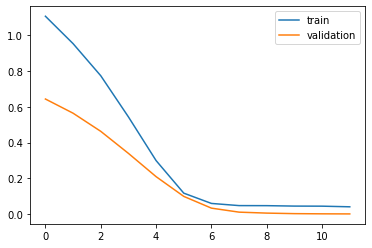

In [61]:

fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='validation')
ax1.legend();

In [62]:
X_test,Y_test = create_dataset(test, test.delay)

modeling to keras  99.9 %

# predicting

In [63]:
y_pred = model.predict(X_test)

In [64]:
y_test_inv, y_pred_inv = unormalizing(Y_test, y_pred)

# unormalizing

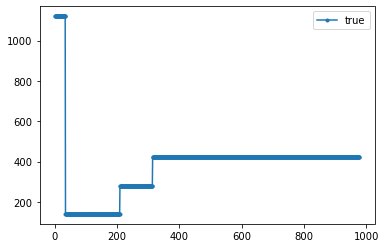

In [65]:
fig2 = plt.figure()
a2 = fig2.add_subplot(1,1,1)
a2.plot(y_test_inv.flatten(), marker='.', label='true')
a2.legend();

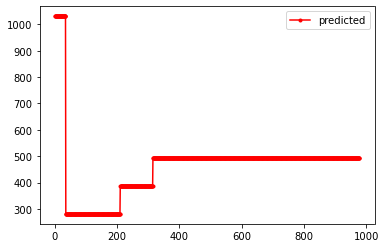

In [66]:
fig3 = plt.figure()
a3 = fig3.add_subplot(1,1,1)
a3.plot(y_pred_inv.flatten(),'r',marker='.', label='predicted')
a3.legend();

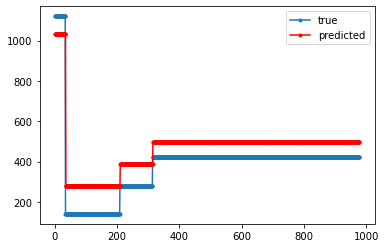

In [67]:
fig4 = plt.figure()
a4 = fig4.add_subplot(1,1,1)

a4.plot(y_test_inv.flatten(), marker='.', label='true')
a4.plot(y_pred_inv.flatten(),'r',marker='.', label='predicted')
a4.legend();

In [68]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import explained_variance_score

In [69]:
size = np.min([y_pred.shape[0],Y_test.shape[0] ])
rmse =  mean_squared_error(Y_test[0:size], y_pred[0:size], squared=False)
mae =  mean_absolute_error(Y_test[0:size], y_pred[0:size])
median_mae = median_absolute_error(Y_test[0:size], y_pred[0:size])
evs = explained_variance_score(Y_test[0:size], y_pred[0:size])

print(rmse)
print(mae)
print(median_mae)
print('Explained Variance Score: ',evs)

0.028202072653749487
0.026199095272257413
0.021444126806997033
Explained Variance Score:  0.9228694990163628


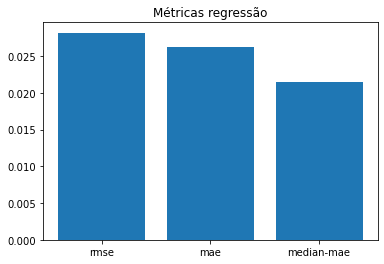

In [70]:
objects = ('rmse', 'mae', 'median-mae')
y_pos = np.arange(3)
performance = [rmse,mae,median_mae]

plt.bar(y_pos, performance, align='center')
plt.xticks(y_pos, objects)
#plt.ylabel('Usage')
plt.title('Métricas regressão')

plt.show()